# Clustering Analisis with mixed cat / num variables

### References
- [prince 0.7.1 - Project description](https://pypi.org/project/prince/#principal-component-analysis-pca)
- [TowardsDataScience - "Are You Still Using the Elbow Method?"](https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd) --> [Notebook in Github](https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb)

In [1]:
%%capture
!pip install prince

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import prince
from prince import FAMD
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklearn_metrics
import math
random_state = 1234

In [14]:
prince.__version__

'0.7.1'

### functions

In [58]:
## Analysis of numerical variables with PCA
def analysis_pca(X:np.array, y:np.array = None, n_components:int = 2):
    """
    Analysis of numerical variables with PCA.
    X -- df or numpy array with numerical features to be analized.
    y -- df series or numpy array with labels to be used to PCs distribution chart.
    n_components -- number of components to be used (default, 2).
    """

    # initialize PCA
    pca = prince.PCA(
         n_components=n_components,
         n_iter=3,
         rescale_with_mean=True,
         rescale_with_std=True,
         copy=True,
         check_input=True,
         engine='auto',
         random_state=42
    )
    # fit PCA
    pca = pca.fit(X)
    # display
    print(f"Number of components selected = {n_components}")
    explained_intertia = pca.explained_inertia_
    total_inertia = np.sum(explained_intertia)
    unexplained_intertia = 1. - total_inertia
    print(f'How much each PC explains part of the underlying of the distribution: {explained_intertia} / Total = {total_inertia} / Unexplained inertia = {unexplained_intertia}')
    # transform
    cs = pca.transform(X)
    
    # plot components 2 first components
    print("Two first components distribution:")
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (10,8))
    ax = pca.plot_row_coordinates(
         X,
         ax=ax,
         #figsize=(6, 6),
         x_component=0,
         y_component=1,
         labels=None,
         color_labels= None if y is None else y,
         ellipse_outline=False,
         ellipse_fill=True,
         show_points=True
    )
    plt.show()    
    
    # correlation between components and variables
    print('Correlation between components and variables:')
    display(pca.column_correlations(X))
    
    # rows contribution
    rows_contribution = pca.row_contributions(X)
    rows_ratio_contribution = rows_contribution / X.shape[0]
    # plot percent of rows contribution
    print("Rows contribution distribution:")
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (10, 6))
    rows_ratio_contribution.plot(ax = ax)
    ax.set_title("Percent of rows contribution", fontsize = 12)
    ax.set_xlabel("Index")
    ax.set_ylabel("%")
    plt.show()   
    
    # return 
    return None


## Automated selection of number of PCs para PCA
def pca_number_pcs_auto_selection(X:np.array, variance_threshold:float = .95, verbose:bool = False):
    """
    Automated selection of number of PCs para PCA.
    X -- df or numpy array with numerical features to be analized.
    variance_threshold -- percent of variance to be used as cut-off threshold.
    verbose -- display extra information (default, False).
    return -- optimed number of pcs.
    """
    # loop of possible components number
    for nc in np.arange(1, X.shape[1]+1, 1):
        # initialize pca
        total_explained_inertia = np.sum(prince.PCA(n_components=nc).fit(X).explained_inertia_)
        # validate
        if total_explained_inertia >= variance_threshold:
            # display result
            if verbose:
                print(f"Optimal number of PCs for {variance_threshold*100.}% cut-off threshold = {nc}")
            # return value of components number
            return nc
    # return if it is not found nothing
    return np.nan

## Clustering Analysis: Only Numerical Variables

### dataset: Iris datast

In [69]:
# load data
X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
y = pd.Series(y).map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
# Standardizing the features
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
X.shape, X_scaled.shape, y.shape

((150, 4), (150, 4), (150,))

### analysis pca + clustering

In [72]:
# number of pcs selection
ncs = pca_number_pcs_auto_selection(X_scaled, variance_threshold=.95, verbose = True)
# pca
pca = prince.PCA(
    n_components=ncs,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
pca = pca.fit(X_scaled)
X_pcs = pca.transform(X_scaled)

Optimal number of PCs for 95.0% cut-off threshold = 2


Number of components selected = 2
How much each PC explains part of the underlying of the distribution: [0.72962445 0.22850762] / Total = 0.9581320720000158 / Unexplained inertia = 0.04186792799998418
Two first components distribution:


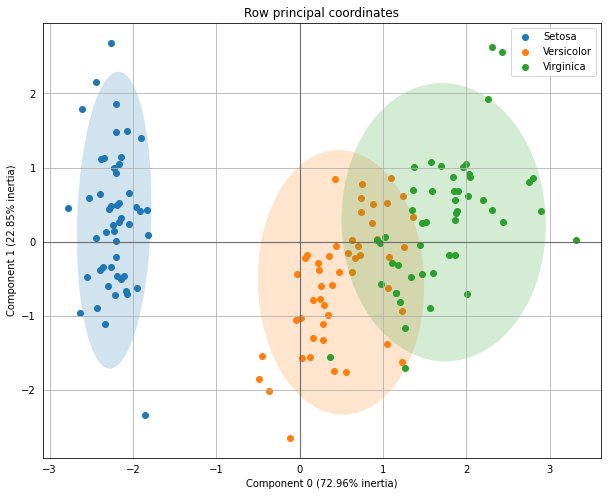

Correlation between components and variables:


,0,1
Petal length,0.991555,0.023415
Petal width,0.964979,0.064000
Sepal length,0.890169,0.360830
Sepal width,-0.460143,0.882716


Rows contribution distribution:


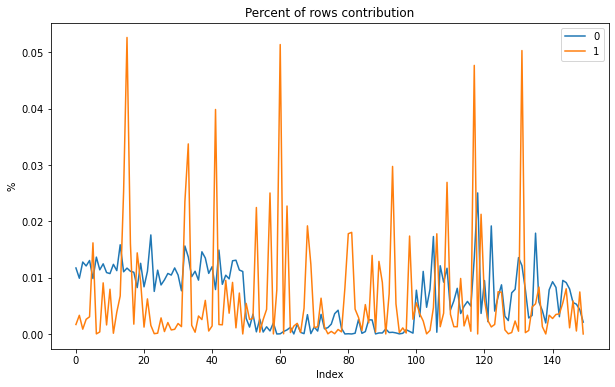

In [71]:
analysis_pca(X_scaled, y, n_components=ncs)

In [94]:
def plot_cluster(X, y, title="Cluster plot"):
    d_colors = {0:'red', 1:'green', 2:'blue'}
    fig = X.plot.scatter(x=0, y=1, color=[d_colors[k] for k in y], title = title)
    return fig


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)
  
def bic_score(X: np.ndarray, labels: np.array):
  """
  BIC score for the goodness of fit of clusters.
  This Python function is translated from the Golang implementation by the author of the paper. 
  The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
  """
    
  n_points = len(labels)
  n_clusters = len(set(labels))
  n_dimensions = X.shape[1]

  n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

  loglikelihood = 0
  for label_name in set(labels):
    X_cluster = X[labels == label_name]
    n_points_cluster = len(X_cluster)
    centroid = np.mean(X_cluster, axis=0)
    variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
    loglikelihood += \
      n_points_cluster * np.log(n_points_cluster) \
      - n_points_cluster * np.log(n_points) \
      - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
      - (n_points_cluster - 1) / 2
    
  bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
        
  return bic

def kmeans_labels(X, n_clusters):
    """Gives the same result of Scikit-learn's Kmeans, but it doesn't throw an error when n_clusters = 1."""
    if n_clusters == 1:
        return np.repeat(a=0, repeats=len(X))
    else:
        return KMeans(n_clusters=n_clusters).fit(X).labels_
    


<AxesSubplot:title={'center':'Continuous Only'}, xlabel='0', ylabel='1'>

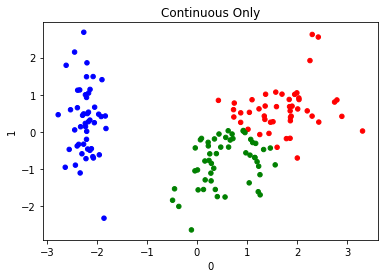

In [95]:
model = KMeans(n_clusters=3, random_state=random_state).fit(X_pcs)
pred = model.labels_
fig = plot_cluster(X_pcs, pred, title="Continuous Only")
fig

In [121]:
possible_k = np.arange(1,10,1)  
ss1 = list()
ss2 = list()
for k in possible_k:
    labels = kmeans_labels(X_pcs, n_clusters=k)
    s1 = calinski_harabasz_score(X_pcs, labels)
    s2 = bic_score(X_pcs.values, labels)
    ss1.append(s1)
    ss2.append(s2)
    print(k, s1, s2)
np.nanargmax(ss1)+1, np.nanargmax(ss2)+1

1 nan -560.2295680480837
2 283.0054876245568 -499.0190826758088
3 293.32801538290283 -498.41173139311667
4 263.81272818499633 -498.48939104772745
5 278.45139528392235 -501.71249802932107
6 262.5390801263203 -490.17843874827616
7 263.16366831168483 -501.15488346876197
8 273.20278323721595 -501.16758651374533
9 298.13746276506606 -498.6858653487062


(9, 6)